In [1]:
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, recall_at_k
import pandas as pd
import numpy as np
import os
import datetime
from clearml import Task, Logger
import boto3
import joblib

/opt/homebrew/lib/python3.11/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
def download_from_s3(bucket_name, s3_key, local_file_path, aws_region='us-east-1'):
    """
    Downloads a file from S3 to a local path.

    Parameters:
    - bucket_name: str, name of the S3 bucket
    - s3_key: str, key of the file in the S3 bucket
    - local_file_path: str, local path to save the downloaded file
    - aws_region: str, AWS region (default: 'us-east-1')
    """
    s3 = boto3.client('s3', region_name=aws_region)
    try:
        with open(local_file_path, 'wb') as f:
            s3.download_fileobj(bucket_name, s3_key, f)
        print(f"Successfully downloaded {s3_key} from s3://{bucket_name} to {local_file_path}")
    except Exception as e:
        raise RuntimeError(f"Failed to download from S3: {e}")
download_from_s3("your-recommender-data", "reviews/user_ratings.csv", "data/user_ratings.csv")
download_from_s3("your-recommender-data", "cleaned/models.csv", "data/models.csv")

Successfully downloaded reviews/user_ratings.csv from s3://your-recommender-data to data/user_ratings.csv
Successfully downloaded cleaned/models.csv from s3://your-recommender-data to data/models.csv


In [3]:
class ProductCollabModel:
    """
    A class to handle the training and recommendation of products using a collaborative filtering model (LightFM).
    """
    def __init__(self, csv_path, save_model_dir, n_reviews=10000, n_components=10, loss='warp', epochs=30, num_threads=4, k=20):
        """
        Initializes the ProductCollabModel.

        Args:
            csv_path (str): The path to the CSV file containing reviews.
            save_model_dir (str): Directory to save the model components.
            n_reviews (int): The number of reviews to use from the dataset.
            n_components (int): The number of latent components for the LightFM model.
            loss (str): The loss function for LightFM ('warp', 'logistic', 'bpr', 'warp-kos').
            epochs (int): The number of training epochs.
            num_threads (int): The number of parallel threads to use for training.
        """
        self.csv_path = csv_path
        self.save_model_dir = save_model_dir
        self.n_reviews = n_reviews
        self.n_components = n_components
        self.loss = loss
        self.epochs = epochs
        self.num_threads = num_threads
        self.k = k
        self.model_path = os.path.join(self.save_model_dir, 'lightfm_collab_model.joblib')
        self.model = None
        self.dataset = None
        self.interactions = None
        self.user_id_map = None
        self.item_id_map = None

        self.train_and_save_model()

    def ndcg_at_k(self):
        n_users, n_items = self.interactions.shape
        ndcg_scores = []

        for user_id in range(n_users):  # Use full user range
            known_items = self.interactions.tocsr()[user_id].indices
            if len(known_items) == 0:
                continue

            scores = self.model.predict(user_id, np.arange(n_items))
            top_k_items = np.argsort(-scores)[:self.k]
            rel = np.isin(top_k_items, known_items).astype(int)

            dcg = (rel / np.log2(np.arange(2, rel.size + 2))).sum()
            ideal_rel = np.sort(rel)[::-1]
            idcg = (ideal_rel / np.log2(np.arange(2, rel.size + 2))).sum()

            ndcg = dcg / idcg if idcg > 0 else 0
            ndcg_scores.append(ndcg)

        return np.array(ndcg_scores)

    def train_and_save_model(self):
        """
        Loads data, trains a LightFM model, saves the model, dataset, and interactions,
        and stores model components within the instance.

        Returns:
            bool: True if training and saving were successful, False otherwise.
        """
        # clearml task setup
        datetime_str = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        task: Task = Task.init(
            project_name="recommendation-systems",
            task_name=f"collab model training - {datetime_str}",
        )
        logger = Logger.current_logger()

        # record parameters
        params = {
            "n_reviews": self.n_reviews,
            "no_components": self.n_components,
            "loss": self.loss,
            "num_epochs": self.epochs,
            "k": self.k,
        }
        task.connect(params)

        # Load data
        try:
            df = pd.read_csv(self.csv_path)
            print(f"Data loaded successfully from {self.csv_path}")
        except FileNotFoundError:
            print(f"Error: File not found at {self.csv_path}")
            return False
        except Exception as e:
            print(f"Error reading CSV file: {e}")
            return False

        # Select a subset of data
        df_subset = df.head(self.n_reviews).copy() # Use copy to avoid SettingWithCopyWarning
        print(f"Using the first {len(df_subset)} reviews for training.")

        # Prepare dataset
        try:
            self.dataset = Dataset()
            # Ensure user and name columns are suitable type (e.g., string)
            df_subset['user'] = df_subset['user'].astype(str)
            df_subset['name'] = df_subset['name'].astype(str)

            self.dataset.fit(df_subset['user'], df_subset['name'])
            self.user_id_map, _, self.item_id_map, _ = self.dataset.mapping()
            print("LightFM dataset fitted.")
        except Exception as e:
            print(f"Error fitting LightFM dataset: {e}")
            return False

        # Build interactions
        try:
            # Ensure rating is numeric
            df_subset['rating'] = pd.to_numeric(df_subset['rating'], errors='coerce')
            df_subset.dropna(subset=['rating'], inplace=True) # Drop rows where rating couldn't be converted

            (self.interactions, _) = self.dataset.build_interactions(
                (row['user'], row['name'], row['rating']) for _, row in df_subset.iterrows()
            )
            print(f"Interactions built. Shape: {self.interactions.shape}")
        except Exception as e:
            print(f"Error building LightFM interactions: {e}")
            return False

        # Train model
        try:
            self.model = LightFM(no_components=self.n_components, loss=self.loss, random_state=42)

            for epoch in range(params["num_epochs"]):
                # only fit partial
                self.model.fit_partial(self.interactions, epochs=1, num_threads=4)

                # precision@k
                precisions = precision_at_k(self.model, self.interactions, k=self.k)
                precision = precisions.mean()
                for user_id, user_precision in enumerate(precisions):
                    logger.report_scalar(
                        title=f"UserPrecision@k={self.k}",
                        series=f"User {user_id}",
                        iteration=epoch,
                        value=user_precision
                    )
                logger.report_scalar(f"Precision@k={self.k}", "Epoch", iteration=epoch, value=precision)
                print(f"Epoch {epoch}/{self.epochs} - Precision@k={self.k}: {precision:.4f}")

                # recall@k
                recall = recall_at_k(self.model, self.interactions, k=self.k).mean()
                logger.report_scalar(f"Recall@k={self.k}", "Epoch", iteration=epoch, value=recall)
                print(f"Epoch {epoch}/{self.epochs} - Recall@k={self.k}: {recall:.4f}")

                # ndcg
                ndcg = self.ndcg_at_k().mean()
                logger.report_scalar(f"NDCG@k={self.k}", "Epoch", iteration=epoch, value=ndcg)
                print(f"Epoch {epoch}/{self.epochs} - NDCG@k={self.k}: {ndcg:.4f}")

            print("LightFM model trained.")
        except Exception as e:
            print(f"Error training LightFM model: {e}")
            return False

        # Prepare data to save
        model_data = {
            'model': self.model,
            'dataset': self.dataset,
            'interactions': self.interactions,
            'user_id_map': self.user_id_map,
            'item_id_map': self.item_id_map
        }

        # Ensure the save directory exists
        os.makedirs(self.save_model_dir, exist_ok=True)

        # Save the model components
        try:
            joblib.dump(model_data, self.model_path)
            task.upload_artifact(name="lightfm_model", artifact_object=self.model_path)
            print(f"Collaborative model data saved to {self.model_path}")
            task.close()
            # Upload to S3
            upload_joblib_to_s3(self.model_path, "your-recommender-data", "models/lightfm_collab_model.joblib")
            return True
        except Exception as e:
            print(f"Error saving collaborative model data to {self.model_path}: {e}")
            return False

    # def _load_model_data(self):
    #     """Loads collaborative model data from the file if not already loaded."""
    #     if self.model is None or self.dataset is None or self.interactions is None:
    #         try:
    #             model_data = joblib.load(self.model_path)
    #             self.model = model_data['model']
    #             self.dataset = model_data['dataset']
    #             self.interactions = model_data['interactions']
    #             self.user_id_map = model_data.get('user_id_map') # Use .get for backward compatibility
    #             self.item_id_map = model_data.get('item_id_map')
    #             # Regenerate maps if they weren't saved (older versions)
    #             if self.user_id_map is None or self.item_id_map is None:
    #                     self.user_id_map, _, self.item_id_map, _ = self.dataset.mapping()
    #             print(f"Collaborative model data loaded successfully from {self.model_path}")
    #             return True
    #         except FileNotFoundError:
    #             print(f"Error: Collaborative model file not found at {self.model_path}")
    #             return False
    #         except KeyError as e:
    #             print(f"Error: Collaborative model file at {self.model_path} is missing expected key: {e}")
    #             return False
    #         except Exception as e:
    #             print(f"Error loading collaborative model data from {self.model_path}: {e}")
    #             return False
    #     return True # Already loaded

    # def recommend_products(self, user_id, top_n=10):
    #     """
    #     Recommends products for a given user using the trained LightFM model.

    #     Args:
    #         user_id (str): The user ID for whom to generate recommendations.
    #         top_n (int): The maximum number of recommendations to return.

    #     Returns:
    #         list: A list of recommended product names (str).
    #         None: If the model cannot be loaded, the user is unknown, or an error occurs.
    #     """
    #     # Ensure model data is loaded
    #     if not self._load_model_data():
    #         return None

    #     if self.model is None or self.dataset is None or self.user_id_map is None or self.item_id_map is None:
    #             print("Error: Model components not properly loaded.")
    #             return None

    #     # Check if user_id exists in the training data
    #     if user_id not in self.user_id_map:
    #         print(f"Error: User '{user_id}' not found in the training data.")
    #         # Option: Return popular items or None
    #         return None # Or implement popular item fallback

    #     try:
    #         # Get the internal user index
    #         internal_user_id = self.user_id_map[user_id]

    #         # Get all item internal IDs
    #         n_users, n_items = self.interactions.shape
    #         item_indices = np.arange(n_items)

    #         # Predict scores for all items for the given user
    #         scores = self.model.predict(internal_user_id, item_indices, num_threads=self.num_threads)

    #         # Get item names back from internal IDs
    #         # Create reverse mapping from internal item ID to original item name
    #         reverse_item_map = {v: k for k, v in self.item_id_map.items()}

    #         # Combine scores with item names
    #         scored_items = sorted(zip(scores, item_indices), key=lambda x: x[0], reverse=True)

    #         # Get top N recommendations (excluding items the user already interacted with, if desired - requires interactions matrix)
    #         # For simplicity, we just return the top N scored items here.
    #         # A more robust implementation might filter out already rated items.
    #         recommended_item_indices = [item_idx for score, item_idx in scored_items[:top_n*2]] # Get more initially to allow filtering
    #         recommended_item_names = [reverse_item_map[idx] for idx in recommended_item_indices if idx in reverse_item_map]


    #         print(f"Generated {len(recommended_item_names[:top_n])} recommendations for user '{user_id}'.")
    #         return recommended_item_names[:top_n]

    #     except KeyError:
    #             print(f"Error: Internal mapping issue for user '{user_id}'.")
    #             return None
    #     except Exception as e:
    #         print(f"Error generating recommendations for user '{user_id}': {e}")
    #         return None
        

In [4]:
collab_model_retrained = ProductCollabModel(csv_path="data/user_ratings_retrained.csv", save_model_dir="models", n_components=10, n_reviews=15000, loss='bpr', epochs=30, num_threads=4, k=20)

ClearML Task: created new task id=5d7ab973a39241e481a8bc88269b810b
2025-05-04 00:58:00,385 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/9e7602bde18c444e97a3cdf3df530812/experiments/5d7ab973a39241e481a8bc88269b810b/output/log
2025-05-04 00:58:00,642 - clearml.Repository Detection - WARNING - Could not read Jupyter Notebook: No template sub-directory with name 'script' found in the following paths:
	/Users/joshualiu/Library/Jupyter
	/Users/joshualiu/Library/Python/3.11/share/jupyter
	/opt/homebrew/opt/python@3.11/Frameworks/Python.framework/Versions/3.11/share/jupyter
	/usr/local/share/jupyter
	/usr/share/jupyter
Data loaded successfully from data/user_ratings_retrained.csv
Using the first 11172 reviews for training.
LightFM dataset fitted.
Interactions built. Shape: (100, 7667)
Epoch 0/30 - Precision@k=20: 0.5555
Epoch 0/30 - Recall@k=20: 0.0994
Epoch 0/30 - NDCG@k=20: 0.9799
Epoch 1/30 - Precision@k=20: 0.5355
Epo

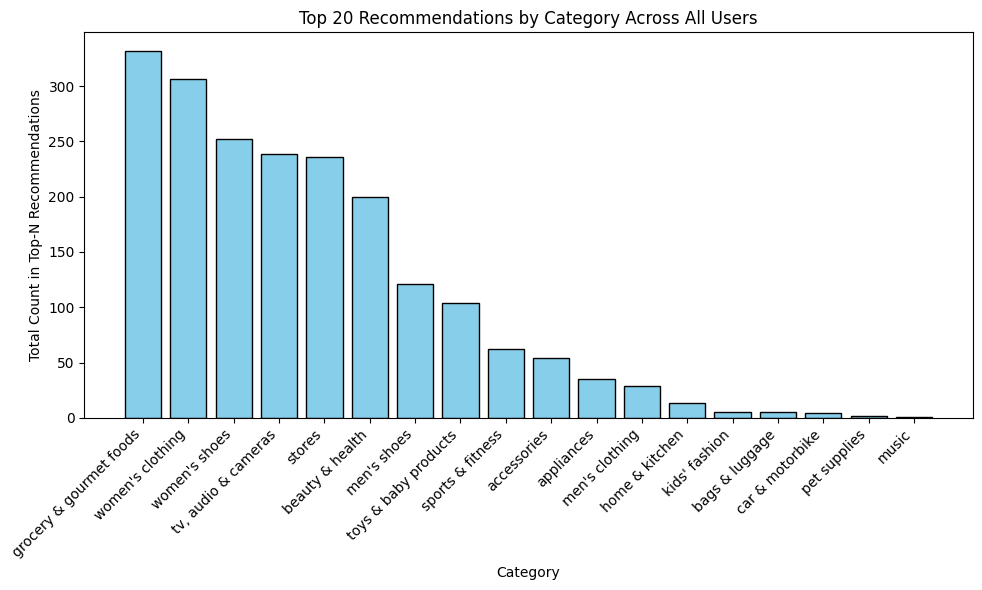

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Load model and mappings
item_index_to_id = {v: k for k, v in collab_model_retrained.item_id_map.items()}
user_ids = list(collab_model_retrained.user_id_map.keys())
user_index_map = collab_model_retrained.user_id_map

# Load metadata
df_models = pd.read_csv("data/models.csv")  # Make sure this has 'name' and 'main_category'
item_to_category = dict(zip(df_models["name"], df_models["main_category"]))

# Parameters
top_n = 20
n_items = len(collab_model_retrained.item_id_map)

# Accumulate category counts
category_counter = Counter()

# Iterate over all users
for user_id in user_ids:
    user_index = user_index_map[user_id]
    scores = collab_model_retrained.model.predict(user_index, np.arange(n_items))
    top_indices = np.argsort(-scores)[:top_n]
    top_item_ids = [item_index_to_id[i] for i in top_indices]

    # Tally categories
    for item in top_item_ids:
        category = item_to_category.get(item)
        if category:
            category_counter[category] += 1

# Convert to DataFrame for plotting
category_df = pd.DataFrame(category_counter.items(), columns=["Category", "Count"])
category_df = category_df.sort_values("Count", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(category_df["Category"], category_df["Count"], color='skyblue', edgecolor='black')
plt.title(f"Top {top_n} Recommendations by Category Across All Users")
plt.xlabel("Category")
plt.ylabel("Total Count in Top-N Recommendations")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Define product details
products = [
    ("Skechers-GO Walk 6 - Bold Knight", 5.0, "men's shoes", "Sports Shoes"),
    ("Big Boon Men's Ethnic Shoes Set of 1 Pair", 5.0, "men's shoes", "Formal Shoes"),
    ("Red Chief Men's Rust Leather Trekking and Hiking Footwear Shoes - 7 UK (RC2020 022)", 4.0, "men's shoes", "Sports Shoes"),
    ("SeeandWear Leather Lace up Formal Shoes for Men", 5.0, "men's shoes", "Formal Shoes"),
    ("FRONTASTIC Men's Grey Walking, Gym Comfortable Casual Symbol Men's Sport Shoes - 2081", 5.0, "men's shoes", "Sports Shoes"),
    ("Puma Mens Softride Vital Strap Running Shoe", 4.0, "men's shoes", "Sports Shoes"),
    ("Skechers Mens Ingram- Marner Sneakers", 4.0, "men's shoes", "Casual Shoes"),
    ("Centrino Men Formal Shoes", 4.0, "men's shoes", "Formal Shoes"),
    ("Stylelure Leather Black Formal Shoes for Men", 4.0, "men's shoes", "Formal Shoes"),
    ("Brighto SHOES Men's", 5.0, "men's shoes", "Casual Shoes"),
]

# Initialize list to store all product rows
data = []

# Loop over users from user1 to user90
index = 11072  # Start index
for user_id in range(1, 21):  # User1 to User90
    for product in products:
        product_name, rating, category, subcategory = product
        row = [index, f"user{user_id}", product_name, rating, category, subcategory]
        data.append(row)
        index += 1  # Increment index for next row

# Convert to DataFrame
df = pd.DataFrame(data, columns=["Index", "User", "Product Name", "Rating", "Category", "Subcategory"])

# Save the DataFrame to a CSV file
df.to_csv("generated_products.csv", index=False)

print("CSV file generated successfully.")


CSV file generated successfully.
